# STA and Merge: Ganglion Cells in the Retina
- **Author**: Javier Cruz
- **Contact**: https://github.com/sisyphvs
- **Last Modification**: January 25, 2024
- **Description**:

## Introduction

### Importing Libraries

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from pylab import rand
from pyret import filtertools
import h5py
import pickle

In [2]:
sys.path.append("../")

In [3]:
from scripts import load_yaml_config

### Paths and configuration

In [4]:
import requests

def download_file(url, destination):
    """ Descarga un archivo desde una URL y lo guarda en un destino especificado. """
    response = requests.get(url, stream=True)

    with open(destination, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024): 
            if chunk:
                file.write(chunk)

In [5]:
plt.style.use("seaborn-v0_8-darkgrid")

In [6]:
configPath = "../config/"
config = load_yaml_config(configPath + "general_config.yml")
SPIKE_TIMES_PATH = ".." + config["paths"]["data"]["result_merged"]
TIMESTAMPS_PATH = ".." + config["paths"]["data"]["start_end_frames"]
STIM_PATH = ".." + config["paths"]["data"]["stim_data"]

### Loading the data

#### Spike times

In [9]:
try:
    units = h5py.File(SPIKE_TIMES_PATH, 'r')
except FileNotFoundError:
    print("File not found, downloading...")
    download_file("https://www.dropbox.com/scl/fi/rpfm0bcqxvnvdcdlc7czn/MR-0387.result-merged.hdf5?rlkey=s464lp1ag069bnxqe6ia8auty&dl=1", SPIKE_TIMES_PATH)
    units = h5py.File(STIM_PATH, 'r')
spt_units = units["spiketimes"]
SPT = {}
for elem in spt_units.keys():
    SPT[elem] = np.array(spt_units[elem])
units.close()

#### Time stamps

In [10]:
TIMESTAMPS_FILE = open(TIMESTAMPS_PATH, 'r')
TIMESTAMPS = []
count = 0
for columns in (raw.strip().split() for raw in TIMESTAMPS_FILE):
    if count == 1:
        pre = float(columns[0])
    if count != 0:
        if pre != float(columns[0]):
            print(pre, columns[0])
        TIMESTAMPS.append((float(columns[0])))
        pre = float(columns[1])
    count=+1
TIMESTAMPS_FILE.close()
TIMESTAMPS = [x for x in TIMESTAMPS if(x >= 28850904 and x <= 52950782)]

#### Total spikes

In [11]:
TOTAL_SPIKES = {}
for stk in SPT.keys():
    st = SPT[stk]
    TOTAL_SPIKES[stk] = len(st[(st > TIMESTAMPS[0]) * (st < TIMESTAMPS[-1])])

#### Stim data

In [12]:
try:
    STIM_FILE = h5py.File(STIM_PATH, 'r')
except FileNotFoundError:
    print("File not found, downloading...")
    download_file("https://www.dropbox.com/scl/fi/99vgo2lcws23hqsn8tg9m/MR-0387.checkboard_stim.mat?rlkey=cml4z44vu0aur3wial9h5j62f&dl=1", STIM_PATH)
    STIM_FILE = h5py.File(STIM_PATH, 'r')
STIM_DATA = []
test = STIM_FILE["stim"]
for i in range(72001):
    st = test[i][0]
    obj = STIM_FILE[st]
    STIM_DATA.append(obj[:][:])
STIM_FILE.close()
STIM_DATA = np.array(STIM_DATA)
for elem in STIM_DATA:
    for i in range(35):
        for j in range(35):
            if elem[i][j] == 1.:
                elem[i][j] = 255.
            elif elem[i][j] == -1.:
                elem[i][j] = 0.

File not found, downloading...


### Constants

In [10]:
FPS = config["params"]["FPS"]
FRAME_TIME = 1/FPS
TIME = np.arange(0,26,1)*FRAME_TIME
TIME_CONT = np.linspace(0,26,260)*FRAME_TIME

## Computing the STA

In [11]:
TIME_DATA = np.array(TIMESTAMPS)
STA_FRAMES = 26
FRAMES_AFTER = 3
HISTORY = STA_FRAMES - FRAMES_AFTER

**_LOOP ENTRY POINT_**

In [62]:
def get_sta(cell):
    sta, tax = filtertools.sta(TIME_DATA, STIM_DATA, SPT[cell], HISTORY, nsamples_after=FRAMES_AFTER)
    return (cell, sta)

In [63]:
STA = {}
for cell in SPT.keys():
    STA[cell] = get_sta(cell)[1]

In [64]:
#STA data set
DATA_STA = list(STA.keys())

S_DATA = {}
T_DATA = {"time": TIME,
          "time_cont": TIME_CONT,
          "contrast": {}}

for c in DATA_STA:
    try:
        #decompose
        s,t = filtertools.decompose(STA[c])

        #center data around horizontal axis
        t_0 = (t[-1] + t[-2] + t[-3] + t[-4] + t[-5])/5
        new_t = t - t_0

        #save data
        S_DATA[c] = s
        T_DATA["contrast"][c] = new_t
    except:
        del STA[c]

### Data filtering 

In [65]:
def get_amplitude(sta,thr):
    vmean = np.mean(sta)
    std = np.std(sta)
    amp = np.max(((np.max(sta)-vmean), abs(np.min(sta)-vmean)))
    if amp > std * thr:
        return np.abs(amp)
    else:
        return 0

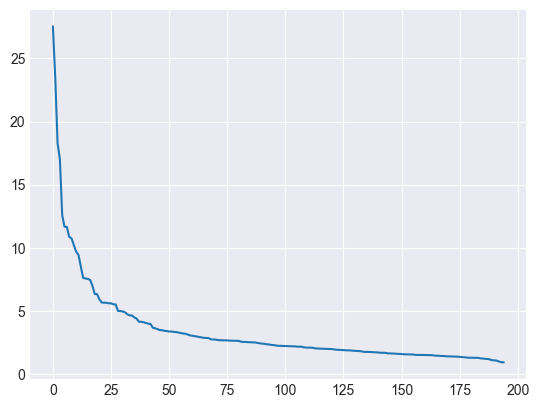

In [66]:
AMPLITUDES = np.zeros(len(STA))
for i, cell in enumerate(STA.keys()):
    AMPLITUDES[i] = get_amplitude(STA[cell], thr = 4)

plt.plot(np.sort(AMPLITUDES)[::-1])
plt.show()

In [67]:
GOOD_STAS = []
for cell in STA.keys():
    if get_amplitude(STA[cell], thr = 4) > 0:
        GOOD_STAS.append(cell)

In [68]:
def get_rfs(keys):
    rfs = {}
    for i, cell in enumerate(keys):
        try:
            s = S_DATA[cell] #filtertools.decompose(stas[cell])
            center, width, theta = filtertools.get_ellipse(s)
            rfs[cell] = {}
            rfs[cell]['x'] = x = float(center[0])
            rfs[cell]['y'] = y = float(center[1])
            rfs[cell]['w'] = w = width[0]
            rfs[cell]['h'] = h = width[1]
            rfs[cell]['a'] = a = theta
            rfs[cell]['exc'] = np.sqrt(1 - ((np.min((h,w))/2)**2/(np.max((h,w))/2)**2))
        except:
            continue
    return rfs

RFS = get_rfs(GOOD_STAS)

In [69]:
len(STA), len(GOOD_STAS), len(RFS), len([c for c in RFS if RFS[c]['exc'] < .9])

(195, 195, 195, 195)

In [70]:
DATA_RFS = [c for c in RFS if RFS[c]['exc'] < .9]

### Ploting the STA

In [71]:
def plot_rfs(rfs, keys,  xmax=40, xmin=0, ymin=0, ymax=40, thrsh=0.9):
    ells = []
    b = 0
    for i, cell in enumerate(keys):
        x = rfs[cell]['x']
        y = rfs[cell]['y']
        w = rfs[cell]['w']
        h = rfs[cell]['h']
        a = rfs[cell]['a']
        exc = rfs[cell]['exc']
        if (exc < thrsh) * (y < xmax) * (x < ymax) * (y > xmin) * (x > ymin):
            ells.append(Ellipse(xy = (y,x), width = w, height = h, angle = a,
                                color = rand(3), fill = False, alpha = 0.6,
                                label = cell.strip('temp_'), linewidth = 2.))
        else:
            b += 1

    fig = plt.figure()
    fig.set_size_inches(8,8)
    ax = fig.add_subplot(111, aspect = 'equal')
    for i, e in enumerate(ells):
        ax.add_artist(e)
        #ax.annotate(e.get_label(), e.get_ellipse)
    fig.suptitle('disp cells = ' + str(len(ells)))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

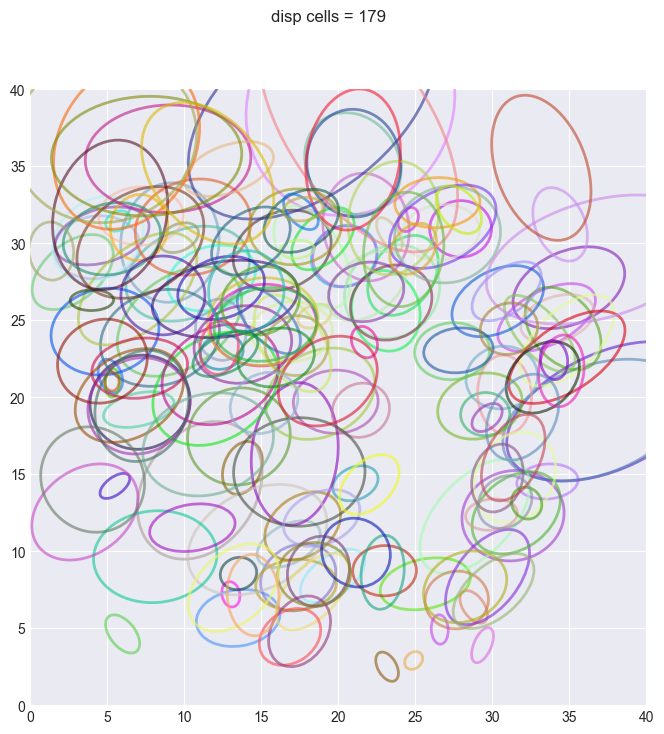

In [72]:
plot_rfs(RFS, RFS.keys())

### Merge Similar

In [73]:
def merge_similar(rfs, cells):
    from itertools import combinations as cb
    sims = 0
    pairs = []
    for a, b in cb(cells, 2):
        x = np.isclose(rfs[a]['x'], rfs[b]['x'], atol = 1)
        y = np.isclose(rfs[a]['y'], rfs[b]['y'], atol = 1)
        w = np.isclose(rfs[a]['w'], rfs[b]['w'], rtol = .3)
        h = np.isclose(rfs[a]['h'], rfs[b]['h'], rtol = .3)
        z = np.isclose(rfs[a]['a'], rfs[b]['a'], rtol = .2)
        #plt.scatter(rfs[a]['x'], rfs[b]['x'])
        if x * y * w * h * z:
            sims += 1
            #print('{} is similar to {}'.format(a, b))
            pairs.append([a,b])
    print('found {} similarities from a maximum of {}'.format(sims, len(cells)**2))
    return pairs

In [74]:
sims = merge_similar(RFS,DATA_RFS)

found 2 similarities from a maximum of 38025


In [75]:
def compare_STA(stas, a, b):
    fig,axs = plt.subplots(2,2)
    fig.set_size_inches(6,6)
    colors = ['k', 'C3', 'C2']
    ells = []
    for i, cell in enumerate([a,b]):
        x = RFS[cell]['x']
        y = RFS[cell]['y']
        w = RFS[cell]['w']
        h = RFS[cell]['h']
        z = RFS[cell]['a']
        #exc = RFS[cell]['exc']
        ells.append(Ellipse(xy = (y, x), width = w, height = h, angle = z,
                            color = colors[i], fill = False, alpha = 0.85, linewidth = 4.))

    for e in ells: 
        axs[1][1].add_artist(e)
    #ax2.set_title()
    sa, ta = filtertools.decompose(stas[a])
    sb, tb = filtertools.decompose(stas[b])
    #vmax = (np.max(abs(sa - sb)))
    axs[1][1].imshow(sa - sb, cmap = 'viridis', interpolation = 'None')
    axs[1][1].set_title('Merge')
    axs[0][1].imshow(sa, cmap = 'viridis', interpolation = 'None')
    axs[1][0].imshow(sb, cmap = 'viridis', interpolation = 'None')
    axs[0][1].set_title('Cell ' + a)
    axs[1][0].set_title('Cell ' + b)
    axs[0][0].plot(ta, label = a, color = colors[0])
    axs[0][0].plot(tb, label = b, color = colors[1])
    axs[0][0].legend()
    axs[0][0].set_xlim([0,None])
    return fig

### Plots

C:\Users\David\AppData\Local\Temp\ipykernel_2976\2056583606.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


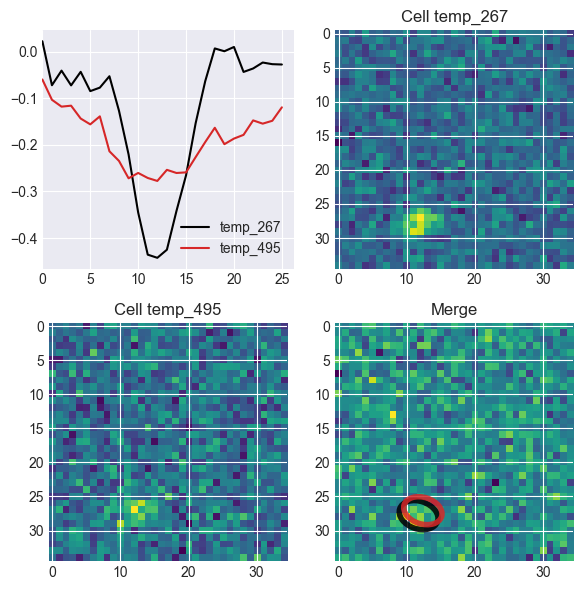

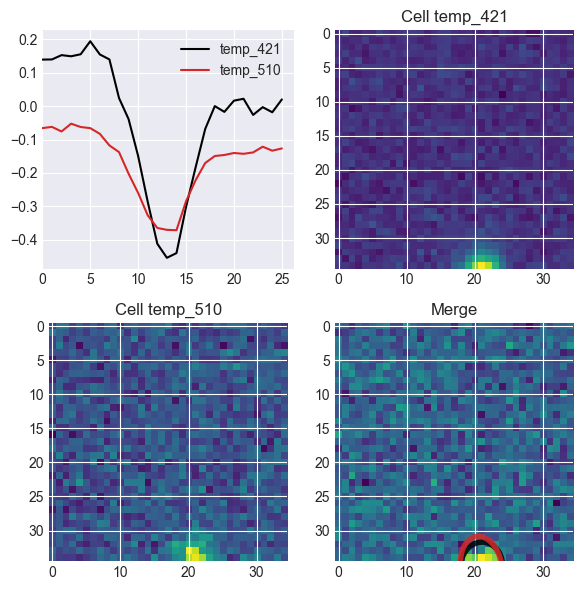

In [76]:
for p in sims:
    fig = compare_STA(STA, p[0], p[1])
    fig.tight_layout()
    fig.show()

### Removing

In [77]:
TO_REMOVE = []

'''TO_REMOVE = [[267,495],
             [421,510]]'''

'''TO_REMOVE = [[267,495],
             [421,510],
             [421,640],
             [422,510],
             [422,640]]'''

for elem in TO_REMOVE:
    if ["temp_" + str(elem[0]),"temp_" + str(elem[1])] in sims:
        sims.remove(["temp_" + str(elem[0]),"temp_" + str(elem[1])])

In [78]:
for sim in sims:
    try:
        print(SPT[sim[1]][0])
    except:
        continue
        
    SPT[sim[0]] = np.sort(np.concatenate((SPT[sim[0]], SPT[sim[1]])))

27790
3925


In [79]:
for s in sims:
    try:
        del DATA_RFS[s[1]]
    except:
        continue

In [80]:
for s in sims:
    try:
        del SPT[s[1]]
    except:
        continue

#### Removing data from TOTALSPIKES and SPT

In [81]:
keys = list(TOTAL_SPIKES.keys()).copy()

In [82]:
for temp in keys:
    if temp not in DATA_RFS:
        try:
            del TOTAL_SPIKES[temp]
        except:
            pass
        try:
            del SPT[temp]
        except:
            pass

In [83]:
zeros = np.zeros(len(TOTAL_SPIKES))
for i, temp in enumerate(TOTAL_SPIKES.keys()):
    zeros[i] = TOTAL_SPIKES[temp]

##### Plot Histogram

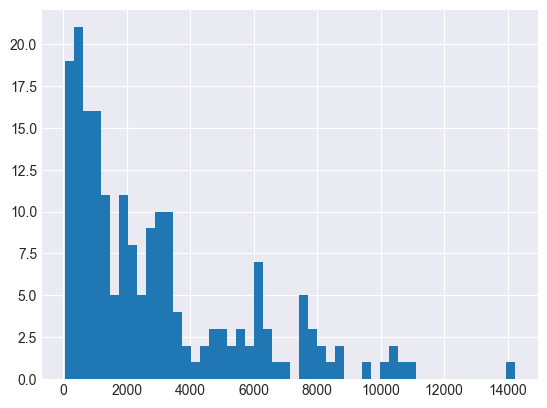

In [84]:
plt.hist(zeros,bins=50)
plt.show()

**_In the Jupyter notebook it was mentioned that the process should be repeated (generating the STA again) until there are no similar RFs_**

## Export data

In [85]:
print(len(DATA_RFS),len(SPT),len(TOTAL_SPIKES))

195 193 195


In [86]:
TO_SAVE = {"STA": STA,
           "S_DATA_STA": S_DATA,
           "T_DATA_STA": T_DATA,
           "SPT": SPT,
           "TIMESTAMPS": TIMESTAMPS,
           "TOTAL_SPIKES": TOTAL_SPIKES,
           "DATA_RFS": DATA_RFS,
           "RFS": RFS}

for elem in TO_SAVE.keys():
    with open("../" + config["paths"]["data_cache"][elem],"wb") as output: 
        pickle.dump(TO_SAVE[elem], output)

___